# Exercise Round 9

## Exercise 1

(a) The Wiener velocity model contains the state with "position" $p(t)$ and its derivative $\dot{p}(t)$, i.e., $\mathbf{x} = [p,\dot{p}]$. The dynamic model is
$$
\mathbf{x}_n = \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix} \, \mathbf{x}_{n-1} + \mathbf{q}_n, \quad \mathbf{q}_n \sim N\left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, q_w \begin{bmatrix} \Delta t^3/3 & \Delta t^2/2 \\ \Delta t^2/2 & \Delta t \end{bmatrix} \right)
$$
If we want to measure the "position" part, we measure the first component of $\mathbf{x}$, which can be picked up by multplying with matrix $\mathbf{G} = \begin{bmatrix} 1 & 0 \end{bmatrix}$. That is, the measurement model should be
$$
y_n = \begin{bmatrix} 1 & 0 \end{bmatrix} \, \mathbf{x}_n + r_n
$$

In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

dt  = 0.1
q_w = 0.1
F = np.array([[1,dt],[0,1]])
print(F)

Q = q_w * np.array([[dt**3/3,dt**2/2],[dt**2/2,dt]])
print(Q)

G = np.array([[1,0]])
print(G)

sd = 0.5
R = np.array([[sd**2]])
print(R)

[[1.  0.1]
 [0.  1. ]]
[[3.33333333e-05 5.00000000e-04]
 [5.00000000e-04 1.00000000e-02]]
[[1 0]]
[[0.25]]


(b) Simulate data from the model

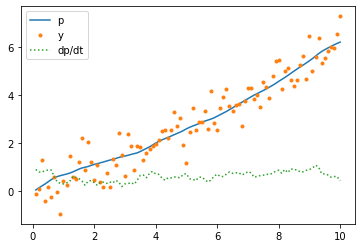

In [2]:
steps = 100
m0 = np.array([0,1])  # Suitable initial mean
P0 = 0.01 * np.eye(2) # Suitable initial covariance

LQ = linalg.cholesky(Q, lower=True)
L0 = linalg.cholesky(P0, lower=True)

T = np.zeros((steps,))
X = np.zeros((steps,2))
Y = np.zeros((steps,1))

x = m0 + L0 @ np.random.normal(size=(m0.shape))
t = 0

for n in range(steps):
    q = LQ @ np.random.normal(size=x.shape)
    x = F @ x + q
    r = sd * np.random.normal()
    y = G @ x + r
    t = t + dt
    T[n] = t
    X[n,:] = x
    Y[n,:] = y

plt.clf()
plt.plot(T,X[:,0],T,Y[:,0],'.',T,X[:,1],':')
plt.legend(['p','y','dp/dt'])

(c) Implement Kalman filter

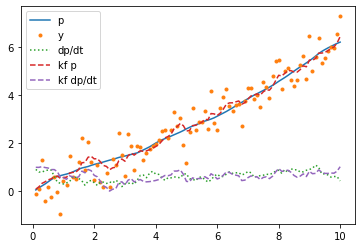

In [3]:
m = m0
P = P0
kf_m = np.zeros((Y.shape[0],m.shape[0]))
kf_P = np.zeros((Y.shape[0],P.shape[0],P.shape[1]))
for n in range(Y.shape[0]):
    # Prediction
    m = F @ m
    P = F @ P @ F.T + Q
    # Update
    S = G @ P @ G.T + R
    K = P @ G.T @ linalg.inv(S)
    m = m + K @ (Y[n] - G @ m)
    P = P - K @ S @ K.T
    kf_m[n,:] = m
    kf_P[n,:,:] = P
    
plt.clf()
plt.plot(T,X[:,0],T,Y[:,0],'.',T,X[:,1],':',T,kf_m[:,0],'--',T,kf_m[:,1],'--')
plt.legend(['p','y','dp/dt','kf p','kf dp/dt'])

In [4]:
p_rmse_raw = np.sqrt(np.mean((Y[:,0] - X[:,0])**2))
print(p_rmse_raw)

0.5753404265157231


In [5]:
p_rmse_kf = np.sqrt(np.mean((kf_m[:,0] - X[:,0])**2))
print(p_rmse_kf)

0.15297382975528778


## Exercise 2

(a) Batch and sequential regularized least squares

In [6]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

G = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,0,0],[0,-1,0],[0,0,-1]])
print(G)
L = 1
b = np.array([0,0,0,L,L,L])
print(b)

[[ 1  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
[0 0 0 1 1 1]


In [7]:
x = np.array([0.3,0.4,0.5])
sigma = 0.1
R = sigma**2 * np.eye(6)
r = np.random.normal(0,sigma,6)
y = G@x + b + r
print(y)

[0.31901969 0.55856298 0.39791164 0.83936145 0.72257616 0.56490821]


In [8]:
m0 = np.array([0.5,0.5,0.5])
P0 = 0.1**2 * np.eye(3) 

x_rls = linalg.inv(G.T @ linalg.inv(R) @ G + linalg.inv(P0)) @ (G.T @ linalg.inv(R) @ (y - b) + linalg.inv(P0) @ m0)
print(x_rls)

[0.32655275 0.44532894 0.44433448]


In [9]:
x_sls = m0
P_sls = P0
for i in range(y.shape[0]):
    Gn = G[i:i+1,:]
    Rn = R[i,i]
    Kn = P_sls @ Gn.T @ linalg.inv(Gn @ P_sls @ Gn.T + Rn)
    x_sls = x_sls + Kn @ (y[i] - b[i] - Gn @ x_sls)
    P_sls = P_sls - Kn @ (Gn @ P_sls @ Gn.T + Rn) @ Kn.T
    print(x_sls)

[0.40950985 0.5        0.5       ]
[0.40950985 0.52928149 0.5       ]
[0.40950985 0.52928149 0.44895582]
[0.32655275 0.52928149 0.44895582]
[0.32655275 0.44532894 0.44895582]
[0.32655275 0.44532894 0.44433448]


(b-c) For the Kalman filter, we can formulate "dynamics" as $\mathbf{x}_n = \mathbf{x}_{n-1}$ which corresponds to $\mathbf{F} = I$ and $\mathbf{Q} = 0$. A single measurement is then given by $y_n = \mathbf{G}_n \, \mathbf{x}_n + r_n$, where $\mathbf{G}_n$ is the $n$th row of $\mathbf{G}$. 

In [10]:
F = np.eye(3)
Q = np.zeros((3,3))

m = m0
P = P0
for n in range(y.shape[0]):
    # Prediction
    m = F @ m
    P = F @ P @ F.T + Q
    # Update
    Gn = G[n:n+1,:] # Make it a matrix for numpy (not a vector)
    S = Gn @ P @ Gn.T + R[n,n]
    K = P @ Gn.T @ linalg.inv(S)
    z = y[n] - b[n] # Need to use y_n - b_n as measurement
    m = m + K @ (z - Gn @ m)
    P = P - K @ S @ K.T
    print(m)


[0.40950985 0.5        0.5       ]
[0.40950985 0.52928149 0.5       ]
[0.40950985 0.52928149 0.44895582]
[0.32655275 0.52928149 0.44895582]
[0.32655275 0.44532894 0.44895582]
[0.32655275 0.44532894 0.44433448]


## Exercise 3

(a) 3D Wiener velocity model

In [11]:
q  = 0.1
dt = 0.1
F = np.array([[1,0,0,dt,0,0],
              [0,1,0,0,dt,0],
              [0,0,1,0,0,dt],
              [0,0,0,1,0,0],
              [0,0,0,0,1,0],
              [0,0,0,0,0,1]])
print(F)

Q = q * np.array([[dt**3/3,0,0,dt**2/2,0,0],
                  [0,dt**3/3,0,0,dt**2/2,0],
                  [0,0,dt**3/3,0,0,dt**2/2],
                  [dt**2/2,0,0,dt,0,0],
                  [0,dt**2/2,0,0,dt,0],
                  [0,0,dt**2/2,0,0,dt]])
print(Q)

# Measure only position part
G2 = np.zeros((6,6))
G2[:,0:3] = G
print(G2)

[[1.  0.  0.  0.1 0.  0. ]
 [0.  1.  0.  0.  0.1 0. ]
 [0.  0.  1.  0.  0.  0.1]
 [0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  1. ]]
[[3.33333333e-05 0.00000000e+00 0.00000000e+00 5.00000000e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.33333333e-05 0.00000000e+00 0.00000000e+00
  5.00000000e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.33333333e-05 0.00000000e+00
  0.00000000e+00 5.00000000e-04]
 [5.00000000e-04 0.00000000e+00 0.00000000e+00 1.00000000e-02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.00000000e-04 0.00000000e+00 0.00000000e+00
  1.00000000e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.00000000e-04 0.00000000e+00
  0.00000000e+00 1.00000000e-02]]
[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.]]


(b) Simulate data and plot

In [12]:
steps = 100

#m0 = np.zeros((6,))
m0 = np.array([0.5,0.5,0.5,1,0,0])
P0 = 0.01 * np.eye(6)

LQ = linalg.cholesky(Q, lower=True)
L0 = linalg.cholesky(P0, lower=True)
LR = linalg.cholesky(R, lower=True)

T = np.zeros((steps,))
X = np.zeros((steps,6))
Y = np.zeros((steps,6))

x = m0 + L0 @ np.random.normal(size=(m0.shape))
t = 0

for n in range(steps):
    q = LQ @ np.random.normal(size=x.shape)
    x = F @ x + q
    r = LR @ np.random.normal(size=G2.shape[0])
    y = G2 @ x + b + r
    t = t + dt
    T[n] = t
    X[n,:] = x
    Y[n,:] = y


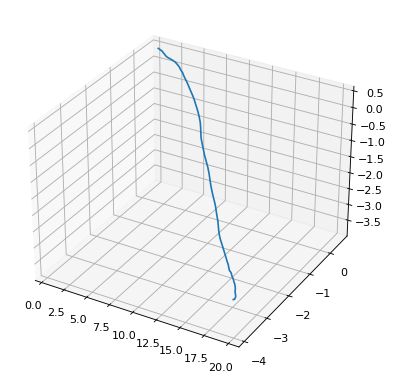

In [13]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(X[:,0], X[:,1], X[:,2])

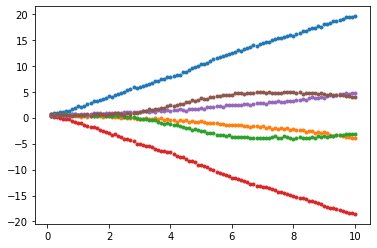

In [14]:
plt.clf()
plt.plot(T,Y[:,0],'.',T,Y[:,1],'.',T,Y[:,2],'.',T,Y[:,3],'.',T,Y[:,4],'.',T,Y[:,5],'.')

(c) Kalman filter

In [15]:
m = m0
P = P0
kf_m = np.zeros((Y.shape[0],m.shape[0]))
kf_P = np.zeros((Y.shape[0],P.shape[0],P.shape[1]))
for n in range(Y.shape[0]):
    # Prediction
    m = F @ m
    P = F @ P @ F.T + Q
    # Update with the full measurements at each step
    S = G2 @ P @ G2.T + R
    K = P @ G2.T @ linalg.inv(S)
    m = m + K @ (Y[n] - b - G2 @ m)
    P = P - K @ S @ K.T
    kf_m[n,:] = m
    kf_P[n,:,:] = P

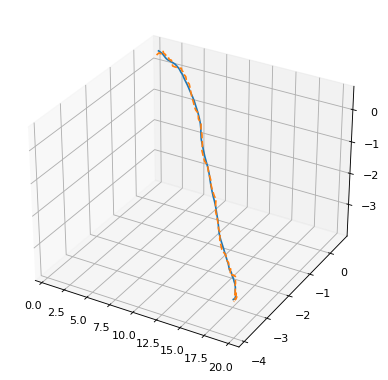

In [16]:
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(X[:,0], X[:,1], X[:,2])
ax.plot3D(kf_m[:,0], kf_m[:,1], kf_m[:,2], '--')

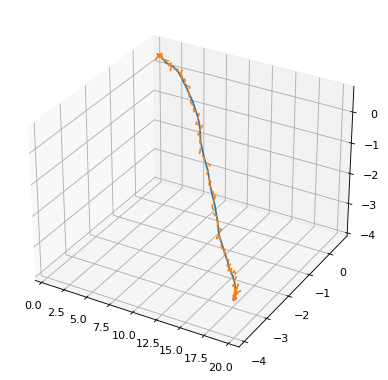

In [17]:
m = np.array([0.5,0.5,0.5])
P = 100.0 * np.eye(3) # Make it almost plain least squares

x_rlss = np.zeros((Y.shape[0],3))

for n in range(Y.shape[0]):
    x_rls = linalg.inv(G.T @ linalg.inv(R) @ G + linalg.inv(P)) @ (G.T @ linalg.inv(R) @ (Y[n] - b) + linalg.inv(P) @ m)
    x_rlss[n,:] = x_rls

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
ax.plot3D(X[:,0], X[:,1], X[:,2])
ax.plot3D(x_rlss[:,0], x_rlss[:,1], x_rlss[:,2], '--')

In [18]:
# Note that there are many definitions of RMSE, this is averaged over coordinates as well
p_rmse_rls = np.sqrt(np.mean((x_rlss[:,0:3] - X[:,0:3])**2))
print(p_rmse_rls)

0.0674336610811344


In [19]:
p_rmse_kf = np.sqrt(np.mean((kf_m[:,0:3] - X[:,0:3])**2))
print(p_rmse_kf)

0.0420125742969669
